<a href="https://colab.research.google.com/github/dnguyend/par-trans/blob/main/examples/JAXStiefelParallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook to test Stiefel parallel transport using JAX

We can choose either CPU or GPU in the hardware setting. There is a time limit on GPU use on the free cloud so you may want to run GPU on your own machine.
We choose CPU here to avoid disruption when we hit time limit. Note [here](https://jax.readthedocs.io/en/latest/faq.html), if you have GPU, JAX is faster - otherwise numpy may be faster.


In [ ]:
#@title Imports & Utils
import ipywidgets as widgets
from IPython.display import display
import subprocess


class credentials_input():
    """To access a private repository
    Include this snippet of codes to colab if you want to access
    a private repository
    """
    def __init__(self, repo_name):
        self.repo_name = repo_name
        self.username = widgets.Text(description='Username', value='')
        self.pwd = widgets.Password(
            description='Password', placeholder='password here')

        self.username.on_submit(self.handle_submit_username)
        self.pwd.on_submit(self.handle_submit_pwd)
        display("Use %40 for @ in email address:")
        display(self.username)

    def handle_submit_username(self, text):
        display(self.pwd)

    def handle_submit_pwd(self, text):
        username = self.username.value.replace('@', '%40')
        # cmd = f'git clone https://{username}:{self.pwd.value}@{self.repo_name}'
        cmd = f'pip install git+https://{username}:{self.pwd.value}@{self.repo_name}'
        process = subprocess.Popen(
            cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, error = process.communicate()
        print(output, error)
        self.username.value, self.pwd.value = '', ''

credentials_input('github.com/dnguyend/par-trans.git')




May take a bit to download - after that you will see "Collecting git+..."

Import the libraries

In [1]:
from time import perf_counter
import timeit
import pandas as  pd

import jax
import jax.numpy as jnp
from jax import jvp, random
from jax_par_trans.expv.utils import (cz, sym)
from jax_par_trans.manifolds import Stiefel


Run several tests:
* check the metric compatible condition of the Levi-Civita connection


In [2]:
jax.config.update("jax_enable_x64", True)
n = 5
d = 3
alp = .6
stf = Stiefel(n, d, alp)

key = random.PRNGKey(0)

x, key = stf.rand_point(key)
v, key = stf.rand_vec(key, x)
va, key = stf.rand_vec(key, x)
c, key = stf.rand_vec(key, jnp.eye(n)[:, :d])

dlt = 1e-6
t = .8

print("CHECK THAT THE CHRISTOFFEL FUNCTION gives a connection. Checking the covariant derivative is tangent")

r1 = jvp(lambda t: stf.proj(x+t*v, va), (0.,), (1.,))[1] + stf.christoffel_gamma(x, v, va)
print(sym(x.T@r1))


CHECK THAT THE CHRISTOFFEL FUNCTION gives a connection. Checking the covariant derivative is tangent
[[-8.09193862e-17  8.46059576e-17 -3.64149466e-18]
 [ 8.46059576e-17 -4.91662432e-17 -1.84453391e-17]
 [-3.64149466e-18 -1.84453391e-17 -1.11040740e-17]]


# Check the covariant derivative is metric compatible
For 2 tangent vectors $v, va$, $X: z\mapsto stf.proj(z, va)$ is a vector field. We compare $D_v\langle X, X\rangle$ and $2\langle X, D_vX + \Gamma(v, X)\rangle$

In [3]:

print("CHECK THAT THE Covariant derivative is metric compatible ")
# print((stf.inner(x+dlt*v, va, va) - stf.inner(x, va, va))/dlt)
print(jax.jvp(lambda z: stf.inner(z, stf.proj(z, va), stf.proj(z, va)), (x,), (v,))[1])
print(2*stf.inner(x, va,
                  jax.jvp(lambda x: stf.proj(x, va), (x,), (v,))[1]
                  + stf.christoffel_gamma(x, v, va)))




CHECK THAT THE Covariant derivative is metric compatible 
-0.35286954597143744
-0.352869545971435


Now check parallel transport. The function stf.exp gives the Riemannian exponential map, while $stf.dexp(x, v, t,ddexp=True) $ computes $\gamma(t), \dot{\gamma}(t)$ and $\ddot{\gamma}(t)$ where $\gamma(t)$ is the geodesic starting at $x$ with initial velocity $\dot{\gamma}(0) = v$. If $ddexp=False$, only $\gamma$ and $\dot{\gamma}$ are returned.

We verify dexp indeed returns the time derivatives, and show the parallel transport equation is satisfied

In [4]:
r1 = stf.exp(x, t*v)

print(cz(jvp(lambda t: stf.exp(x, t*v), (t,), (1.,))[1]
          - stf.dexp(x, v, t, ddexp=False)[1]))

print(cz(jvp(lambda t: stf.dexp(x, v, t)[1], (t,), (1.,))[1]
          - stf.dexp(x, v, t, ddexp=True)[2]))

gmms = stf.dexp(x, v, t, ddexp=True)
print(cz(gmms[2] + stf.christoffel_gamma(gmms[0], gmms[1], gmms[1])))

Delta = stf.parallel(x, v, va, t)

print((stf.parallel(x, v, va, t+dlt) - Delta)/dlt \
      + stf.christoffel_gamma(gmms[0], gmms[1], Delta))

print(jvp(lambda t: stf.parallel(x, v, va, t), (t,), (1.,))[1] \
      + stf.christoffel_gamma(gmms[0], gmms[1], Delta))


2.4424906541753444e-15
8.881784197001252e-16
2.220446049250313e-15
[[-2.84297823e-06 -4.83947300e-07  9.33831980e-07]
 [-7.90234774e-07  2.38673858e-07 -5.09914374e-07]
 [ 1.08708948e-06  5.52772819e-08  5.36002989e-08]
 [-7.23537918e-07  6.26828784e-07  1.25244656e-08]
 [-2.54394720e-06 -7.34161443e-07  1.34519032e-07]]
[[ 0.00000000e+00 -5.55111512e-17  5.41233725e-16]
 [ 2.77555756e-16 -3.33066907e-16  8.32667268e-17]
 [-1.66533454e-15 -1.11022302e-15  6.66133815e-16]
 [ 4.44089210e-16  5.55111512e-16  5.63785130e-16]
 [-4.44089210e-16  6.66133815e-16 -1.11022302e-16]]


A quick check on the speed of parallel. This runs slower in CPU than GPU.

In [5]:
%timeit stf.parallel(x, v, va, t)

217 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# test a bigger manifold.
Still checking the Levi-Civita connection:

Covariant derivative

In [6]:
jax.config.update("jax_enable_x64", True)
n = 400
d = 200
alp = .6
stf = Stiefel(n, d, alp)

key = random.PRNGKey(0)

x, key = stf.rand_point(key)
v, key = stf.rand_vec(key, x)
va, key = stf.rand_vec(key, x)
c, key = stf.rand_vec(key, jnp.eye(n)[:, :d])

dlt = 1e-6
t = .8

print("CHECK COVARIANT DERIVATIVE RETURNS A VECTOR FIELD")
r1 = jvp(lambda t: stf.proj(x+t*v, va), (0.,), (1.,))[1] + stf.christoffel_gamma(x, v, va)
print(cz(sym(x.T@r1)))

# print((stf.inner(x+dlt*v, va, va) - stf.inner(x, va, va))/dlt)
# print(2*stf.inner(x, va, stf.christoffel_gamma(x, v, va)))
print("CHECK METRIC COMPATIBILITY")
print(jax.jvp(lambda z: stf.inner(z, stf.proj(z, va), stf.proj(z, va)), (x,), (v,))[1])
print(2*stf.inner(x, va,
                  jax.jvp(lambda x: stf.proj(x, va), (x,), (v,))[1]
                  + stf.christoffel_gamma(x, v, va)))





CHECK COVARIANT DERIVATIVE RETURNS A VECTOR FIELD
2.5757174171303632e-14
CHECK METRIC COMPATIBILITY
-109.4400230948701
-109.44002309486713


# Check  the parallel transport equation

In [7]:

r1 = stf.exp(x, t*v)

print(cz(jvp(lambda t: stf.exp(x, t*v), (t,), (1.,))[1]
          - stf.dexp(x, v, t, ddexp=False)[1]))

print(cz(jvp(lambda t: stf.dexp(x, v, t)[1], (t,), (1.,))[1]
          - stf.dexp(x, v, t, ddexp=True)[2]))

gmms = stf.dexp(x, v, t, ddexp=True)
print(cz(gmms[2] + stf.christoffel_gamma(gmms[0], gmms[1], gmms[1])))

Delta = stf.parallel(x, v, va, t)

print("CHECK THE transport equation using numerical derivative")
print(cz((stf.parallel(x, v, va, t+dlt) - Delta)/dlt \
      + stf.christoffel_gamma(gmms[0], gmms[1], Delta)))

print("CHECK THE transport equation using AD")
print(cz(jvp(lambda t: stf.parallel(x, v, va, t), (t,), (1.,))[1] \
      + stf.christoffel_gamma(gmms[0], gmms[1], Delta)))


7.505107646466058e-14
2.611244553918368e-13
5.968558980384842e-13
CHECK THE transport equation using numerical derivative
0.0003640411825198697
CHECK THE transport equation using AD
3.6770586575585185e-13


# check execution time

In [8]:
%timeit stf.dexp(x, v, t, ddexp=True)

224 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit stf.parallel(x, v, va, t)

3.22 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# TEST ISOMETRY

We show the inner product metric is preserved to around $10^{-12}$ accuracy up to $t=15$. THis will take a while to run. The graph in the paper comes from a different run, but is mostly compatible

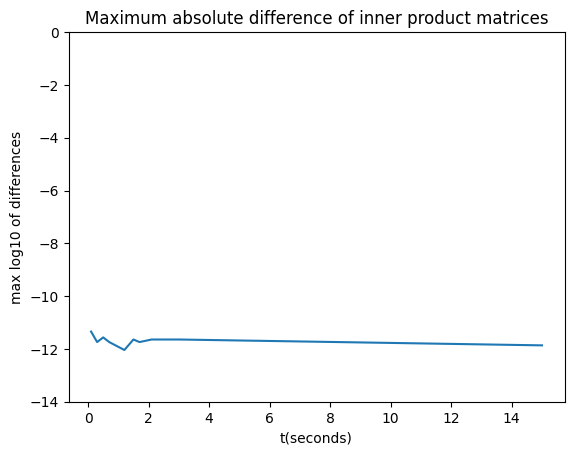

In [10]:
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import jax.numpy.linalg as jla
from jax_par_trans.expv.utils import (grand)

key = random.PRNGKey(0)

n = 1000
d = 200
alp = 1.
stf = Stiefel(n, d, alp)
x = jnp.zeros((n, d)).at[:d, :].set(jnp.eye(d))

n_samples = 20

all_smpl = []

def normalize(a, x):
    return a / jnp.sqrt(stf.inner(x, a, a))

for _ in range(n_samples):
    spl, key = stf.rand_vec(key, x)
    ft = random.choice(key, n_samples*3, (), replace=True)

    all_smpl.append(ft*normalize(spl, x))

all_smpl = jnp.array(all_smpl)


def cal_cov(gm, smpls):
    mat = jnp.zeros((n_samples,  n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            mat = mat.at[i, j].set(stf.inner(gm, smpls[i, :, :], smpls[j, :, :]))
            if i != j:
                mat = mat.at[j, i].set(mat[i, j])
    return mat

cov_0 = cal_cov(x, all_smpl)

v, key = stf.rand_vec(key, x)
v = v/jnp.sqrt(stf.inner(x, v, v))

cov_diff = []
# t_grid = [0.5, 1., 2., 5., 10., 15.]
t_grid = [0.1, .3, .5, .7, 1.2, 1.5, 1.7, 2.1, 3., 15.]
for t in t_grid:
    transported = []
    for i in range(n_samples):
        transported.append(stf.parallel(x, v, all_smpl[i, :, :], t))

    transported = jnp.array(transported)
    gm = stf.exp(x, t*v)
    cov_t = cal_cov(gm, transported)
    # print(cz(cov_t- cov_0))
    cov_diff.append((t, cov_t))

plt.plot(t_grid, [jnp.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])
plt.ylim(-14, 0)
plt.xlabel("t(seconds)")
plt.ylabel("max log10 of differences")
plt.title("Maximum absolute difference of inner product matrices")
plt.savefig("cov_diff_stief.png")
plt.show()


## Speed of the customized expv using JAX

The code can run under both CPU and GPU, with GPU provides a significant speed up, of around 8 or more times depending on hardware.

In [11]:
from jax_par_trans.manifolds.stiefel import StiefelParallelOperator
n = 1000
d = 500

key = random.PRNGKey(0)
alp = .6
stf = Stiefel(n, d, alp)
x = jnp.concatenate([jnp.eye(d), jnp.zeros((n-d, d))])

def normalize(x, ar):
    return ar/jnp.sqrt(stf.inner(x, ar, ar))

ar, key = stf.rand_vec(key, x)
b, key = stf.rand_vec(key, x)
c, key = stf.rand_vec(key, x)

ar = normalize(x, ar)
b = normalize(x, b)
c = normalize(x, c)

salp = jnp.sqrt(alp)

t = 1.2
sp_opt = StiefelParallelOperator({"ar": ar, "alpha": alp})

# run a warm up
w = stf._sc(sp_opt.expv(stf._sc(b, salp), t), 1/salp)

t0 = perf_counter()
w = stf._sc(sp_opt.expv(stf._sc(b, salp), t), 1/salp)
t1 = perf_counter()
# around 93 mseconds here
print(1000*(t1 - t0))


681.5956789996562


# Check effect of changing n, d, and t
This takes the most time  -  we  move it to last. This may run faster on a home machine than on a free colab session.

In [12]:
def test_one_set(stf, key, t_interval, n_samples=10, n_repeats=5):
    ret = []
    d = stf.shape[1]
    for _ in range(n_samples):
        ret_spl = []
        x, key = stf.rand_point(key)
        v, key = stf.rand_vec(key, x)
        va, key = stf.rand_vec(key, x)
        # compile the git
        stf.dexp(x, v, 1.)
        par = stf.parallel(x, v, va, 1.)

        for t in t_interval:
            ret_t = []
            for _ in range(n_repeats):
                t0 = perf_counter()
                gmms = stf.dexp(x, v, t)
                t1 = perf_counter()
                t_gmms = t1 - t0

                t3 = perf_counter()
                par = stf.parallel(x, v, va, t)
                t4 = perf_counter()
                t_par = t4 - t3

                # check accuracy:
                geo_man = cz(gmms[0].T@gmms[0] - jnp.eye(d))
                par_tan = cz(sym(gmms[0].T@par))
                par_eq = cz(jvp(lambda t: stf.parallel(x, v, va, t), (t,), (1.,))[1] +
                            stf.christoffel_gamma(gmms[0], gmms[1], par))

                ret_t.append([t_gmms, t_par, geo_man, par_tan, par_eq])


            ret_spl.append(ret_t)
        ret.append(ret_spl)

    return jnp.array(ret)


def test_time():
    jax.config.update("jax_enable_x64", True)
    key = random.PRNGKey(0)

    d_list = jnp.array([5, 10, 20,  200,  500])
    n_list = jnp.array([100, 200, 500,  1000, 2000])

    alp_list = jnp.array([.4, .5, .7, 1., 1.2])
    t_interval = jnp.array([.5, 1., 2., 5., 20.])


    # first test, fixed d = 100
    d_list = jnp.array([50])
    n_list = jnp.array([100, 200, 1000, 2000])

    alp_list = jnp.array([.5, 1.])

    all_ret_0 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue
            for i_alp in range(alp_list.shape[0]):
                stf = Stiefel(n, d, alp_list[i_alp])
                ret = test_one_set(stf, key, t_interval, n_samples=5, n_repeats=2)
                all_ret_0[int(d), int(n), i_alp] = ret

    tbl = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_0.items():
            tbl.append([idx[1], idx[2], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl = []
    for idx, val in all_ret_0.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl.append([idx[1], idx[2], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl).to_pickle('by_n.pkl')

    # second test, fix n = 2000, test d = [5, 10, 20, 200]
    d_list = jnp.array([5, 10, 20, 100])
    n_list = jnp.array([1000])

    alp_list = jnp.array([.5, 1.])

    all_ret_1 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue
            for i_alp in range(alp_list.shape[0]):
                stf = Stiefel(n, d, alp_list[i_alp])
                ret = test_one_set(stf, key, t_interval, n_samples=5, n_repeats=2)
                all_ret_1[int(d), int(n), i_alp] = ret

    tbl1 = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_1.items():
            tbl1.append([idx[0], idx[2], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl1 = []
    for idx, val in all_ret_1.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl1.append([idx[0], idx[2], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl1).to_pickle('by_d_1000.pkl')


test_time()

Doing n=100 d=50
Doing n=200 d=50
Doing n=1000 d=50
Doing n=2000 d=50
Doing n=1000 d=5
Doing n=1000 d=10
Doing n=1000 d=20
Doing n=1000 d=100


In [13]:

def display_test():
    import numpy as np
    jax.config.update("jax_enable_x64", True)
    by_n_tbl = pd.read_pickle('by_n.pkl')
    # by_n_tbl.iloc[:, 2:] = np.array(by_n_tbl.iloc[:, 2:])
    by_n_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_n_tbl.iloc[:, 2].values]
    by_n_tbl.columns = ['n', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']
    by_n_tbl['log_err_eq'] = [jnp.log10(a) for a in by_n_tbl.err_eq.values]

    by_n_prep = by_n_tbl.pivot_table(index=['alp', 'n'],
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')
    def str1(a):
        return '%.1f' % a

    def str2(a):
        return '%.2f' % a

    # print(by_n_prep.to_latex(formatters=5*[str1] + 5*[str2]))
    # alp_tbl = jnp.array([.5, 1.])
    # by_n_tbl.loc[:, 'alp'] = alp_tbl[by_n_tbl.loc[:, 'alp'].values]
    display(by_n_prep)
    if False:
      by_d_tbl = pd.read_pickle('by_d_1000.pkl')
      by_d_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_d_tbl.iloc[:, 2].values]
      by_d_tbl.columns = ['d', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']

      by_d_tbl['log_err_eq'] = [jnp.log10(a) for a in by_d_tbl.err_eq.values]

      by_d_prep = by_d_tbl.pivot_table(index=['alp', 'd'],
                                      columns='t',
                                      values=['par_time', 'log_err_eq'],
                                      aggfunc='mean')

      print(by_d_prep.to_latex(formatters=5*[str1] + 5*[str2]))

    by_d_tbl = pd.read_pickle('by_d_1000.pkl')
    by_d_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_d_tbl.iloc[:, 2].values]
    by_d_tbl.columns = ['d', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']

    by_d_tbl['log_err_eq'] = [jnp.log10(a) for a in by_d_tbl.err_eq.values]

    by_d_prep = by_d_tbl.pivot_table(index=['alp', 'd'],
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')
    display(by_d_prep)
    # print(by_d_prep.to_latex(formatters=5*[str1] + 5*[str2]))

display_test()

log_err_eq                                              par_time  \
t              00.5       01.0       02.0       05.0       20.0      00.5   
alp n                                                                       
0   100  -13.211626 -13.121452 -13.001253 -12.768483 -12.407119  0.333784   
    200  -13.014526 -12.899027 -12.736122 -12.550022  -12.16544  0.344643   
    1000 -12.541499 -12.348278 -12.158411 -11.997758 -11.601838  0.408651   
    2000  -12.35228 -12.100909 -11.939904 -11.642844  -11.23149  0.497063   
1   100  -13.132472 -12.981218 -12.862172 -12.659383  -12.22587  0.333324   
    200  -13.082224 -12.911253 -12.776031 -12.516636 -12.141287  0.362954   
    1000 -12.837727 -12.674686 -12.480938 -12.277561 -11.917324  0.405322   
    2000 -12.785852 -12.581756 -12.451085 -12.172896 -11.742844  0.498468   

                                                  
t             01.0      02.0      05.0      20.0  
alp n                                             
0   100   0.342919  0.373377  0.474047  0.681911  
    200   0.346638  0.444748  0.541062  0.707054  
    1000  0.422751  0.469166  0.602309  1.129804  
    2000  0.571095  0.593496  0.728584  1.463074  
1   100   0.348137  0.378202  0.492604  1.063403  
    200   0.418552  0.421004  0.555645  1.108336  
    1000   0.56217  0.461483  0.683292  1.645622  
    2000  0.512387  0.617386  0.933514  1.941929

log_err_eq                                              par_time  \
t             00.5       01.0       02.0       05.0       20.0      00.5   
alp d                                                                      
0   5   -13.274619 -13.043078  -12.79897 -12.433491 -11.980806  0.224874   
    10  -12.857502 -12.614558 -12.397403 -12.283761 -11.842399  0.307043   
    20  -12.787933 -12.530525 -12.339061 -12.087316  -11.62687  0.341267   
    100 -12.406243  -12.22737 -12.092909 -11.760416 -11.413643  0.682342   
1   5   -13.470161 -13.286925 -13.081916 -12.799842 -12.376949  0.208323   
    10  -13.370025 -13.141965 -12.940499 -12.780859 -12.336737  0.282931   
    20  -13.076181 -12.849933 -12.700555 -12.434774 -11.943198  0.293468   
    100 -12.535124 -12.389286 -12.204035 -12.046894 -11.646887  0.953929   

                                                  
t            01.0      02.0      05.0       20.0  
alp d                                             
0   5    0.196679  0.200785   0.21808   0.234976  
    10   0.279588  0.239542  0.239278   0.252896  
    20   0.317518   0.32259  0.345408   0.364086  
    100  0.964587  1.312297  2.305966   8.685925  
1   5    0.220571  0.223165  0.218334   0.204757  
    10   0.253023  0.236731  0.236579   0.281704  
    20   0.308804  0.412193  0.310707   0.434881  
    100    1.2662  2.055559  3.892358  13.992766